In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score


In [28]:
# Muat dataset
df_mat = pd.read_csv('dataset/student-mat.csv', sep=';')
df_por = pd.read_csv('dataset/student-por.csv', sep=';')

# Gabungkan dataset
df = pd.concat([df_mat, df_por])


In [29]:
# Lihat sekilas data
print(df.head())
print(df.describe())
print(df.info())

  school sex   age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F  18.0       U     GT3       A   4.0   4.0  at_home   teacher   
1     GP   F  17.0       U     GT3       T   1.0   1.0  at_home     other   
2     GP   F  15.0       U     LE3       T   1.0   1.0  at_home     other   
3     GP   F  15.0       U     GT3       T   4.0   2.0   health  services   
4     GP   F  16.0       U     GT3       T   3.0   3.0    other     other   

   ... freetime goout  Dalc  Walc  health absences    G1    G2    G3  \
0  ...      3.0   4.0   1.0   1.0     3.0      6.0   5.0   6.0   6.0   
1  ...      3.0   3.0   1.0   1.0     3.0      4.0   5.0   5.0   6.0   
2  ...      3.0   2.0   2.0   3.0     3.0     10.0   7.0   8.0  10.0   
3  ...      2.0   2.0   1.0   1.0     5.0      2.0  15.0  14.0  15.0   
4  ...      3.0   2.0   1.0   2.0     5.0      4.0   6.0  10.0  10.0   

  school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failur

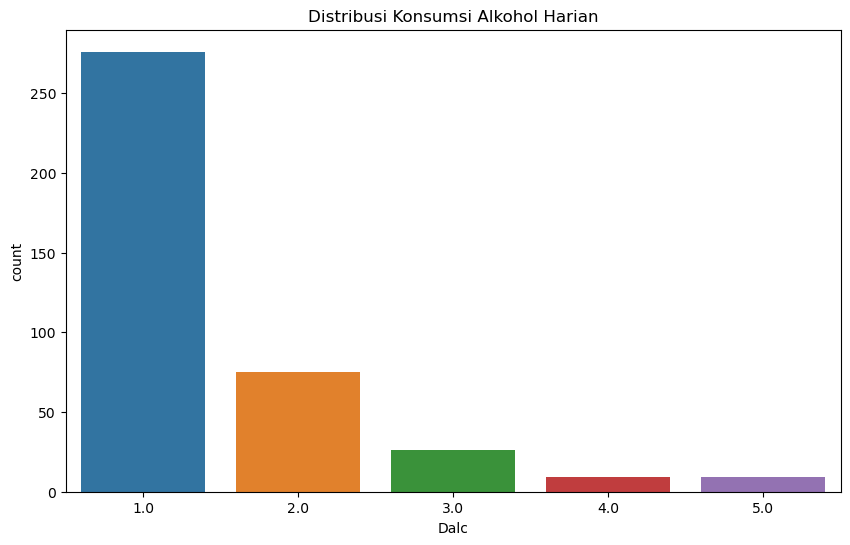

In [30]:
# Visualisasi distribusi konsumsi alkohol harian
plt.figure(figsize=(10, 6))
sns.countplot(x='Dalc', data=df)
plt.title('Distribusi Konsumsi Alkohol Harian')
plt.show()

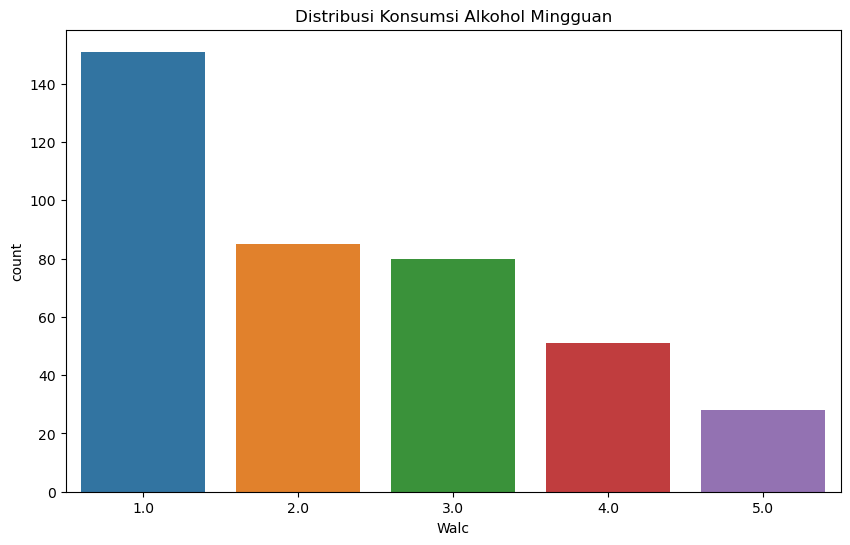

In [31]:
# Visualisasi distribusi konsumsi alkohol mingguan
plt.figure(figsize=(10, 6))
sns.countplot(x='Walc', data=df)
plt.title('Distribusi Konsumsi Alkohol Mingguan')
plt.show()

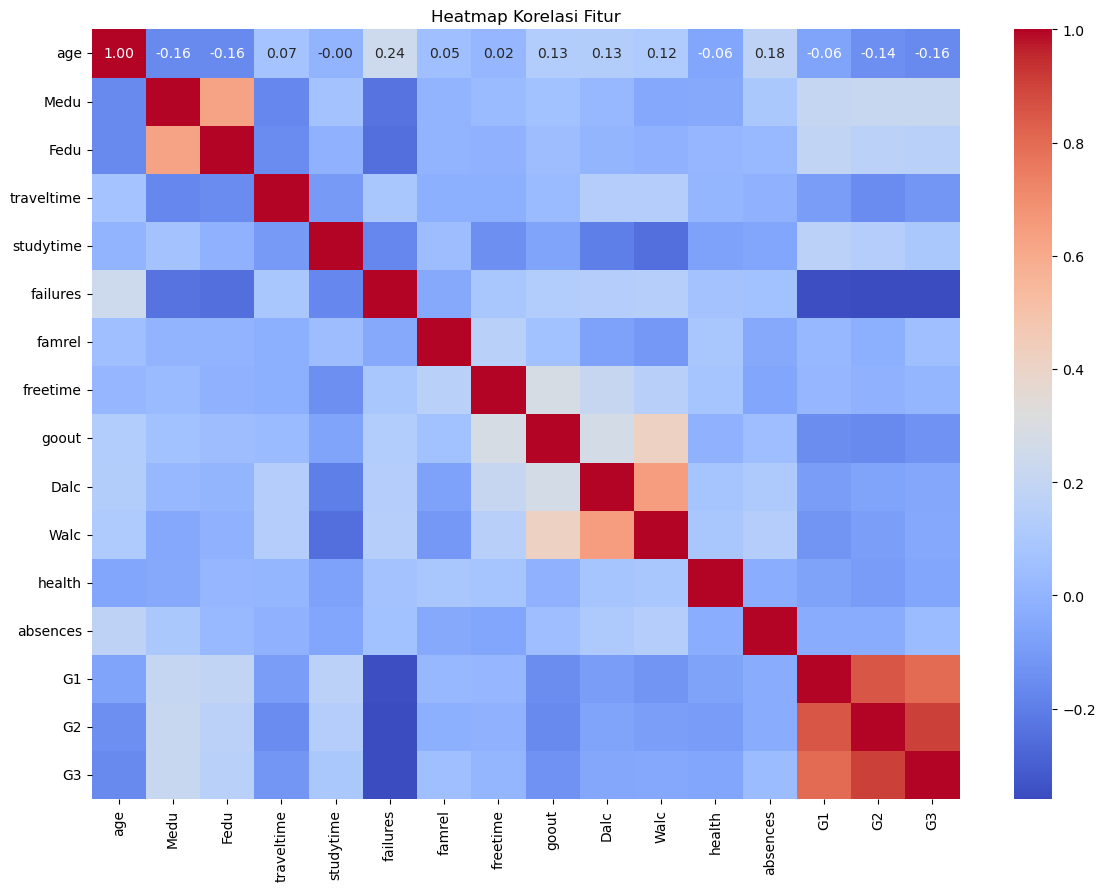

In [32]:
# Hanya gunakan kolom numerik untuk heatmap korelasi
df_numeric = df.select_dtypes(include=[np.number])

# Korelasi antara fitur
plt.figure(figsize=(14, 10))
sns.heatmap(df_numeric.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Heatmap Korelasi Fitur')
plt.show()

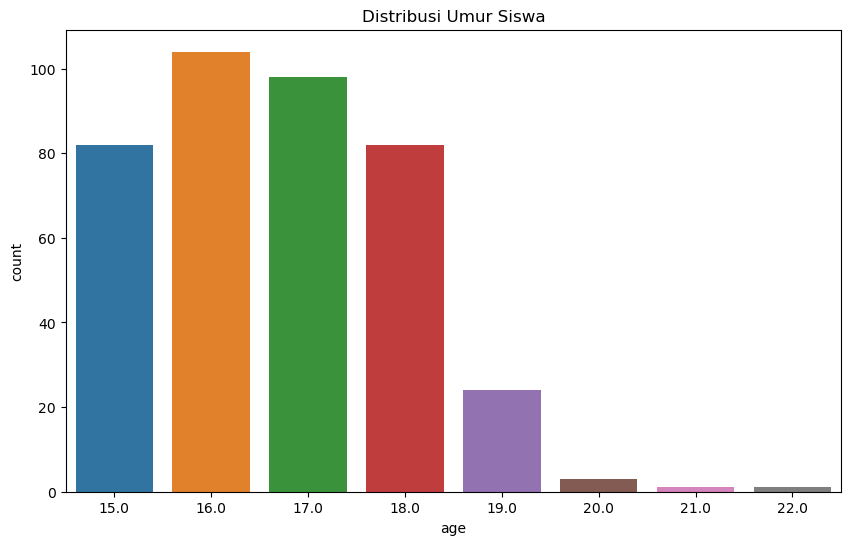

In [33]:
# Visualisasi distribusi umur
plt.figure(figsize=(10, 6))
sns.countplot(x='age', data=df)
plt.title('Distribusi Umur Siswa')
plt.show()

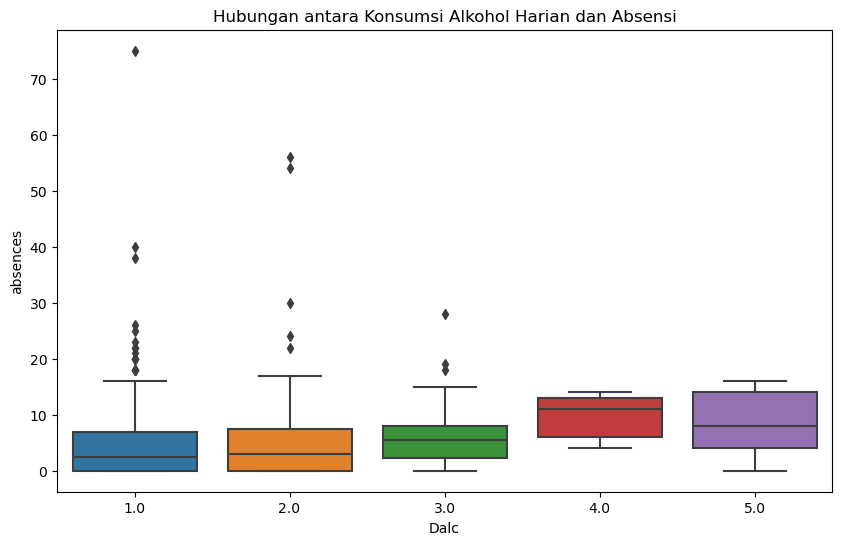

In [34]:

# Analisis hubungan antara konsumsi alkohol dan absensi
plt.figure(figsize=(10, 6))
sns.boxplot(x='Dalc', y='absences', data=df)
plt.title('Hubungan antara Konsumsi Alkohol Harian dan Absensi')
plt.show()



In [35]:
# Pilih fitur dan label
X = df.drop(['Dalc', 'Walc'], axis=1)
y = df['Dalc']

# Menghapus baris dengan nilai NaN pada target
df_cleaned = df.dropna(subset=['Dalc', 'Walc'])

# Memperbarui X dan y dengan data yang telah dibersihkan
X = df_cleaned.drop(['Dalc', 'Walc'], axis=1)
y = df_cleaned['Dalc']

# Identifikasi fitur kategorikal dan numerik
categorical_features = X.select_dtypes(include=['object']).columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns

# One-hot encoding untuk fitur kategorikal
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)])

# Transformasi fitur
X_preprocessed = preprocessor.fit_transform(X)

# Bagi dataset menjadi data latih dan uji
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.3, random_state=42)


In [36]:
# Inisialisasi model
log_reg = LogisticRegression(max_iter=1000)
rf_clf = RandomForestClassifier()

# Grid search untuk hyperparameter tuning
param_grid_log_reg = {'C': [0.01, 0.1, 1, 10, 100]}
grid_log_reg = GridSearchCV(log_reg, param_grid_log_reg, cv=5)
grid_log_reg.fit(X_train, y_train)

param_grid_rf = {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30]}
grid_rf = GridSearchCV(rf_clf, param_grid_rf, cv=5)
grid_rf.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'n_estimators': [100, 200, 300]})

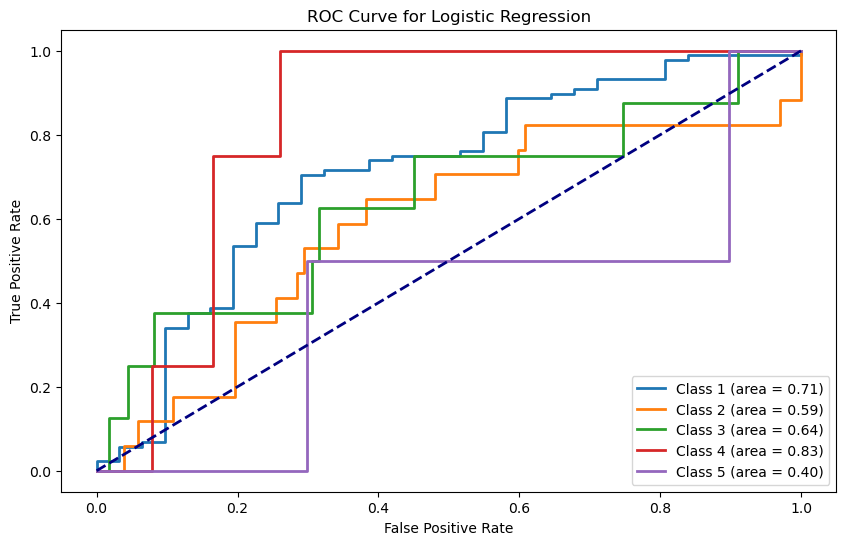

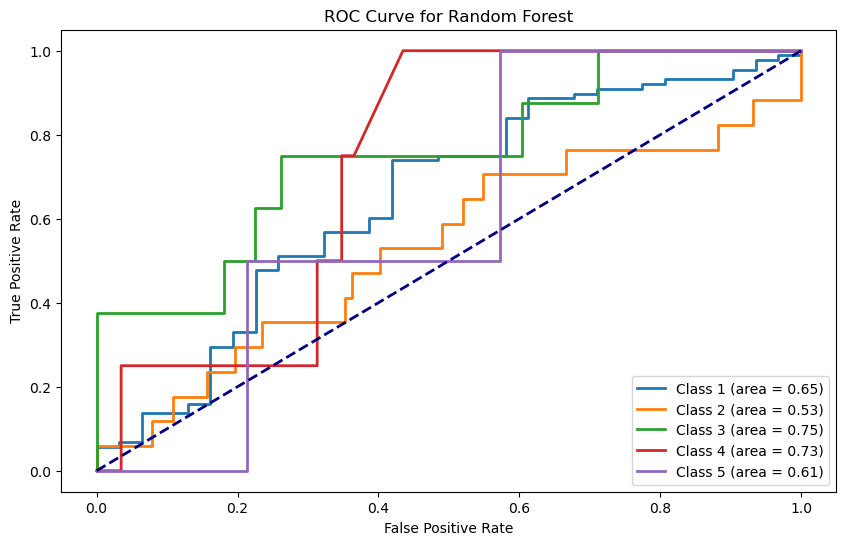

In [37]:
# Binarize labels untuk multiclass ROC AUC
y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4, 5])
n_classes = y_test_bin.shape[1]

# Prediksi probabilitas
y_score_log_reg = grid_log_reg.predict_proba(X_test)
y_score_rf = grid_rf.predict_proba(X_test)

# ROC Curve dan AUC untuk setiap kelas
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score_log_reg[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curve untuk setiap kelas
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i+1} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc='lower right')
plt.show()

# ROC Curve dan AUC untuk setiap kelas dengan Random Forest
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score_rf[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curve untuk setiap kelas
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i+1} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest')
plt.legend(loc='lower right')
plt.show()


In [38]:

# Evaluasi Logistic Regression
y_pred_log_reg = grid_log_reg.predict(X_test)
log_reg_accuracy = accuracy_score(y_test, y_pred_log_reg)
log_reg_precision = precision_score(y_test, y_pred_log_reg, average='weighted', zero_division=0)
log_reg_recall = recall_score(y_test, y_pred_log_reg, average='weighted')
log_reg_f1 = f1_score(y_test, y_pred_log_reg, average='weighted')

print(f'Logistic Regression - Accuracy: {log_reg_accuracy}')
print(f'Logistic Regression - Precision: {log_reg_precision}')
print(f'Logistic Regression - Recall: {log_reg_recall}')
print(f'Logistic Regression - F1 Score: {log_reg_f1}')

# Evaluasi Random Forest
y_pred_rf = grid_rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_precision = precision_score(y_test, y_pred_rf, average='weighted', zero_division=0)
rf_recall = recall_score(y_test, y_pred_rf, average='weighted')
rf_f1 = f1_score(y_test, y_pred_rf, average='weighted')

print(f'Random Forest - Accuracy: {rf_accuracy}')
print(f'Random Forest - Precision: {rf_precision}')
print(f'Random Forest - Recall: {rf_recall}')
print(f'Random Forest - F1 Score: {rf_f1}')

Logistic Regression - Accuracy: 0.6974789915966386
Logistic Regression - Precision: 0.6019534027203115
Logistic Regression - Recall: 0.6974789915966386
Logistic Regression - F1 Score: 0.6456495112823037
Random Forest - Accuracy: 0.7058823529411765
Random Forest - Precision: 0.6485064974001833
Random Forest - Recall: 0.7058823529411765
Random Forest - F1 Score: 0.6450306271148314


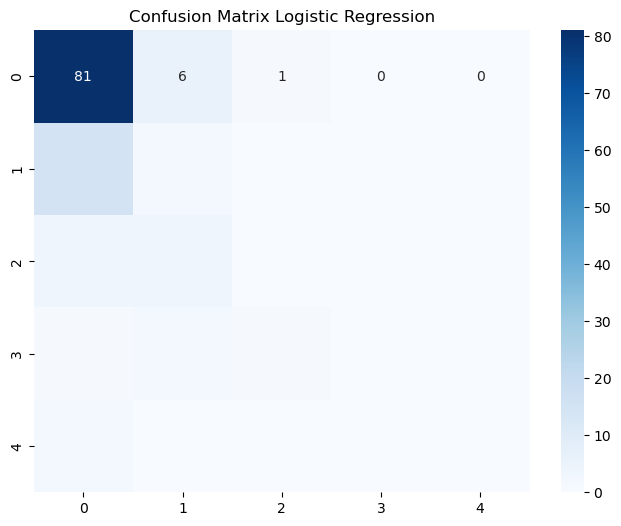

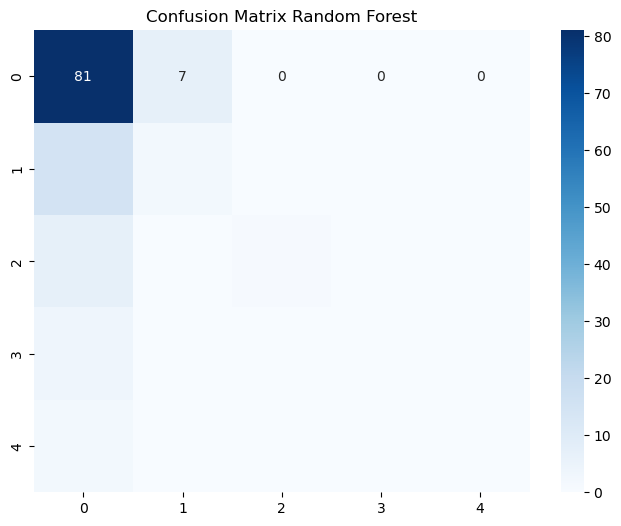

In [39]:
# Visualisasi Confusion Matrix Logistic Regression
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_log_reg), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix Logistic Regression')
plt.show()

# Visualisasi Confusion Matrix Random Forest
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix Random Forest')
plt.show()


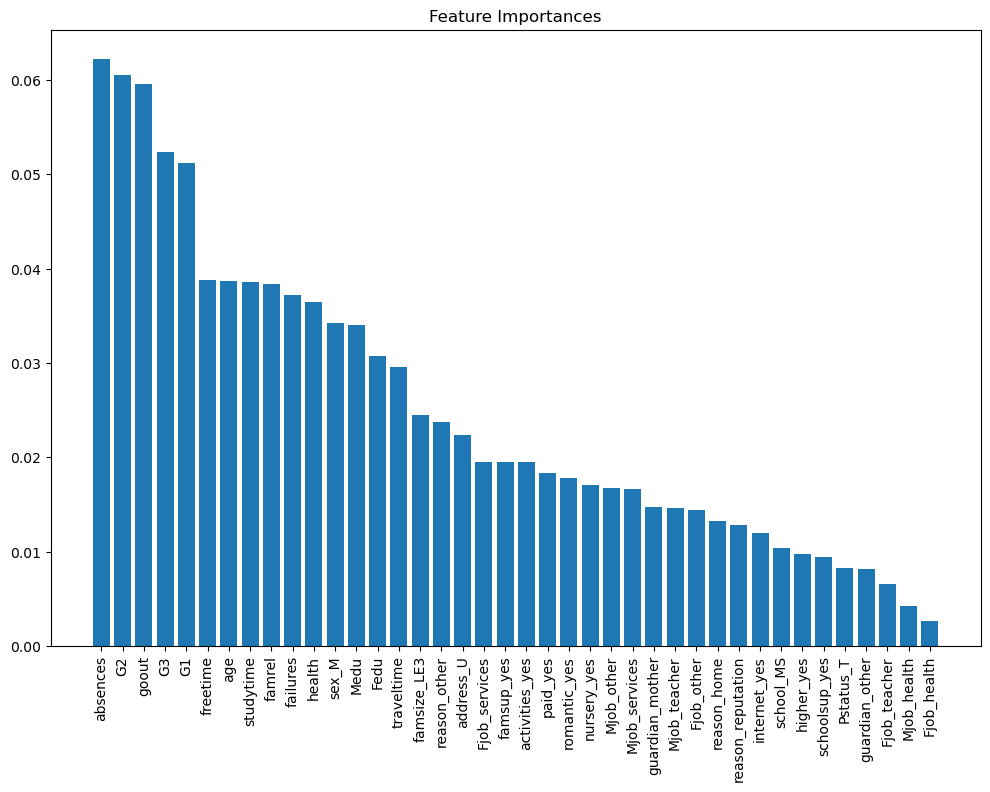

In [40]:
# Feature importance dari Random Forest
importances = grid_rf.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]

# Mendapatkan nama fitur setelah transformasi
feature_names_num = numeric_features.tolist()
feature_names_cat = preprocessor.transformers_[1][1].get_feature_names_out(categorical_features).tolist()
feature_names = feature_names_num + feature_names_cat

# Memastikan jumlah fitur dan importance sama
assert len(feature_names) == len(importances), "Jumlah fitur dan importance tidak sesuai"

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.title('Feature Importances')
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.show()
